# Imports

In [15]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [16]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [17]:
def MLPR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline com MLPRegressor
    pipeline = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(15, 10),     # Aumenta a capacidade para capturar detalhes
            activation='relu',               # Troca para ReLU
            solver='adam',
            alpha=0.3,                       # Reduz a regularização para maior flexibilidade
            max_iter=3000,
            random_state=42,
            learning_rate='adaptive',
            learning_rate_init=0.0003,       # Ajusta a taxa de aprendizado inicial
            batch_size=16
        )
    )


    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    #loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df

# Ajusta saída

In [18]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])


def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# SNV - MPLR

=== Training Metrics ===
R²: 0.9014
Correlation coefficient: 0.9513
RMSE: 0.8174
MAE: 0.6007
Relative absolute error: 28.0620
Root relative squared error: 31.4065
Slope: 0.9412
Offset: 0.8093
=== Cross-Validation Metrics ===
R²: -0.5842
Correlation coefficient: 0.5108
RMSE: 3.2760
MAE: 2.4896
Relative absolute error: 116.2983
Root relative squared error: 125.8660
Slope: 0.3602
Offset: 9.0442
=== Validation Metrics ===
R²: -0.3853
Correlation coefficient: 0.5480
RMSE: 2.6442
MAE: 2.0537
Relative absolute error: 110.4852
Root relative squared error: 117.7008
Slope: 0.3989
Offset: 8.4566


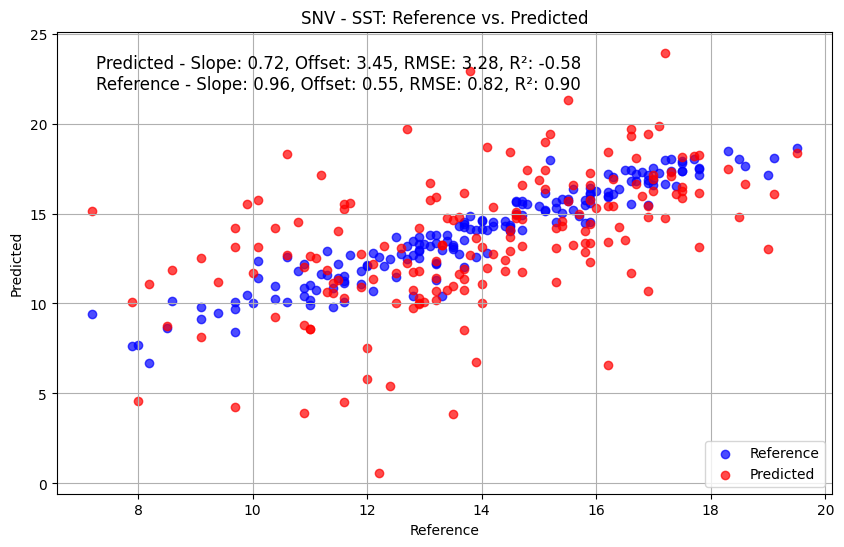

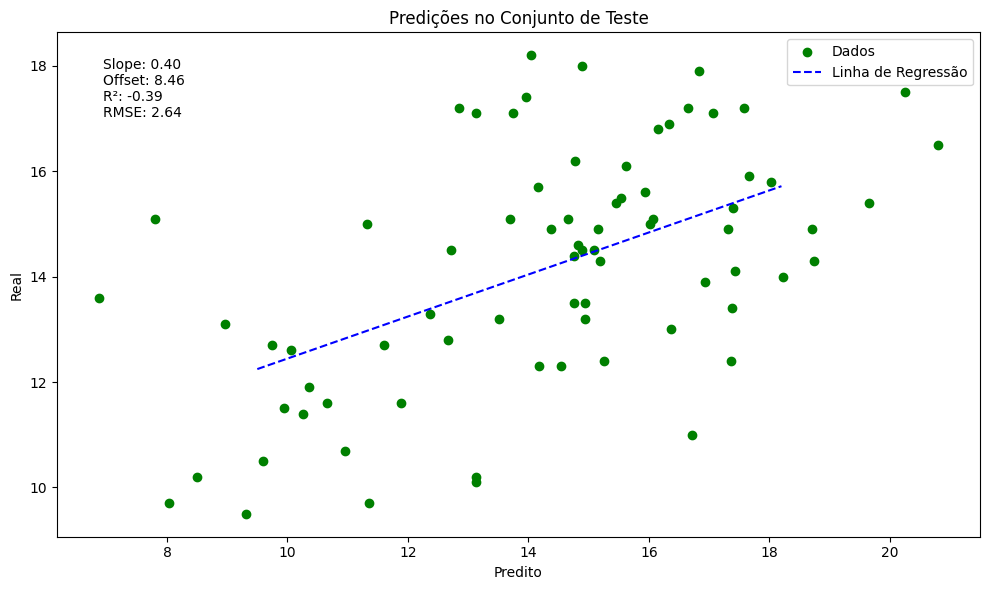

C:\Users\Luyza\AppData\Local\Temp\ipykernel_2216\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [19]:
results_snv_sst = MLPR(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'SST')

=== Training Metrics ===
R²: 0.8909
Correlation coefficient: 0.9447
RMSE: 0.1847
MAE: 0.1330
Relative absolute error: 31.4843
Root relative squared error: 33.0349
Slope: 1.0152
Offset: -0.0390
=== Cross-Validation Metrics ===
R²: -0.1617
Correlation coefficient: 0.4666
RMSE: 0.6027
MAE: 0.4185
Relative absolute error: 99.0554
Root relative squared error: 107.7832
Slope: 0.4388
Offset: 0.6691
=== Validation Metrics ===
R²: 0.3100
Correlation coefficient: 0.7166
RMSE: 0.4266
MAE: 0.3192
Relative absolute error: 75.9304
Root relative squared error: 83.0660
Slope: 0.6159
Offset: 0.4002


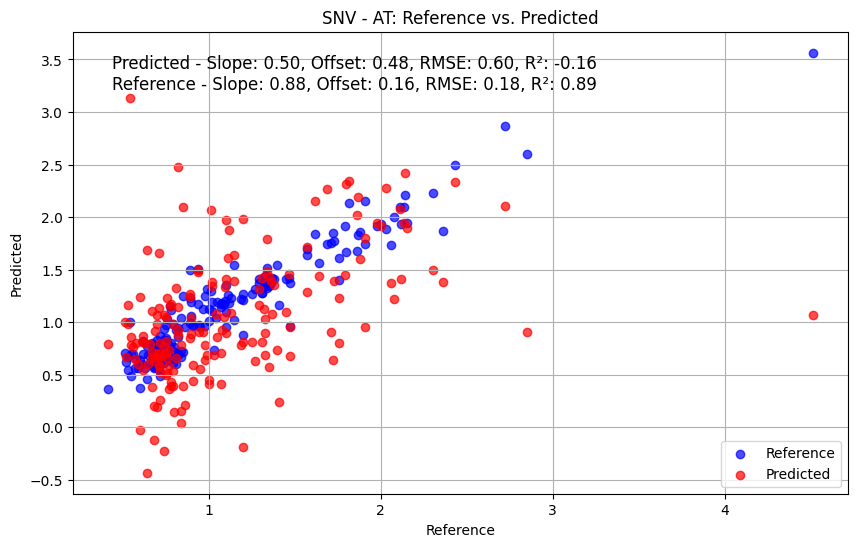

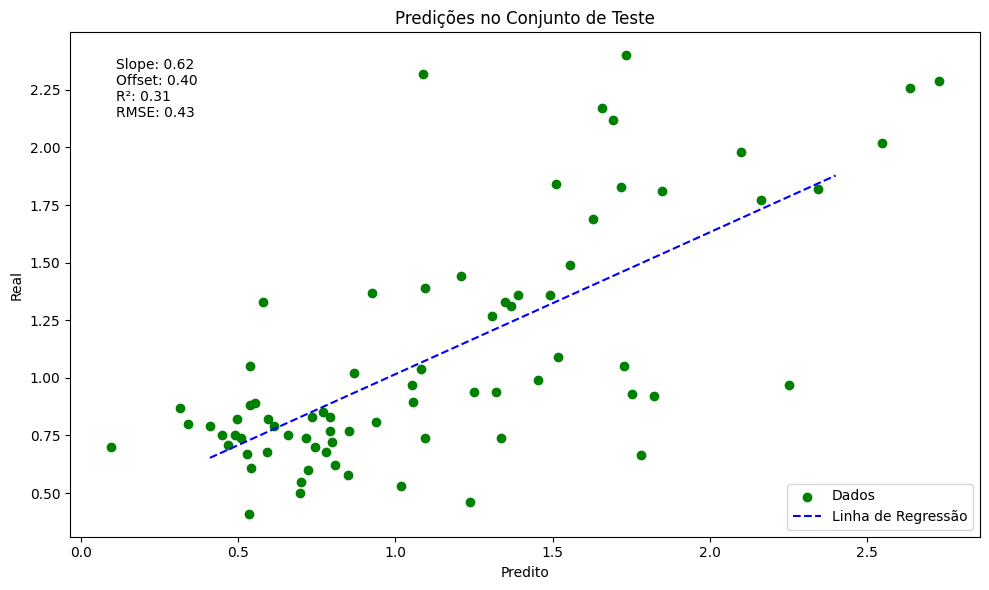

In [20]:
results_snv_at = MLPR(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
infos_snv = add_plot_infos(infos_snv, results_snv_at, 'AT')

=== Training Metrics ===
R²: 0.5484
Correlation coefficient: 0.7986
RMSE: 0.2104
MAE: 0.1648
Relative absolute error: 66.2583
Root relative squared error: 67.2049
Slope: 0.7283
Offset: 0.9026
=== Cross-Validation Metrics ===
R²: -4.1026
Correlation coefficient: 0.2310
RMSE: 0.7073
MAE: 0.5400
Relative absolute error: 217.1515
Root relative squared error: 225.8896
Slope: 0.1043
Offset: 2.9723
=== Validation Metrics ===
R²: -1.7136
Correlation coefficient: 0.4634
RMSE: 0.4067
MAE: 0.3077
Relative absolute error: 145.3262
Root relative squared error: 164.7299
Slope: 0.2509
Offset: 2.4290


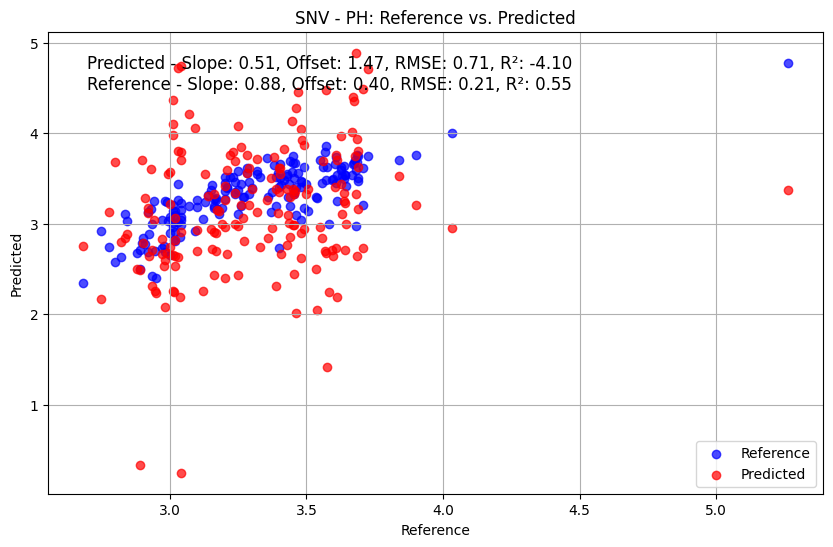

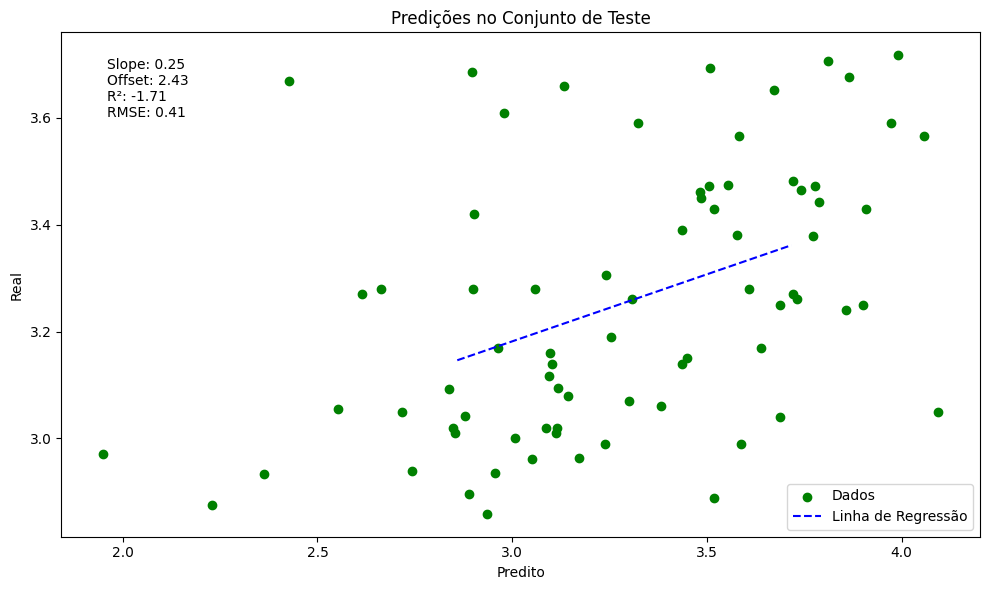

In [21]:
results_snv_ph = MLPR(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
infos_snv = add_plot_infos(infos_snv, results_snv_ph, 'PH')

=== Training Metrics ===
R²: 0.9821
Correlation coefficient: 0.9917
RMSE: 13.5217
MAE: 9.6554
Relative absolute error: 11.9384
Root relative squared error: 13.3759
Slope: 1.0393
Offset: -20.3102
=== Cross-Validation Metrics ===
R²: -0.3462
Correlation coefficient: 0.4336
RMSE: 117.2903
MAE: 93.8669
Relative absolute error: 116.0614
Root relative squared error: 116.0258
Slope: 0.3725
Offset: 321.4933
=== Validation Metrics ===
R²: 0.0141
Correlation coefficient: 0.6729
RMSE: 81.2818
MAE: 66.4462
Relative absolute error: 99.0415
Root relative squared error: 99.2918
Slope: 0.5057
Offset: 243.7671


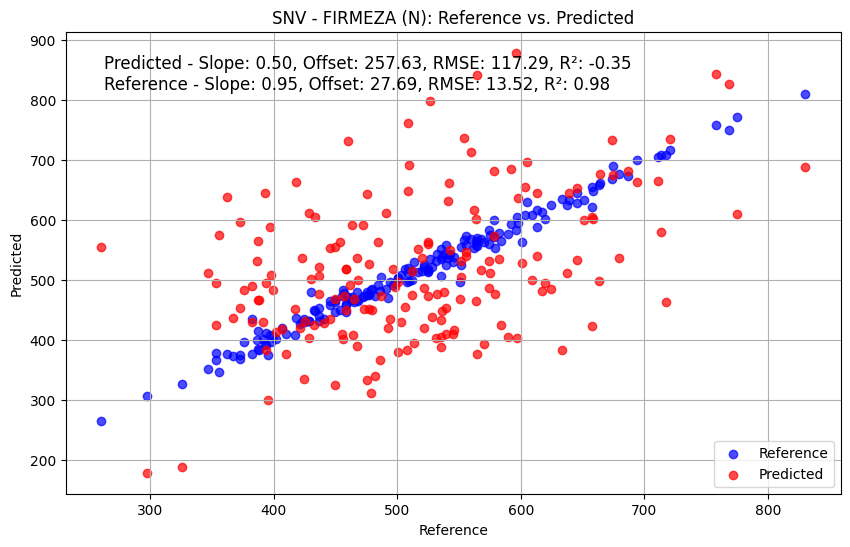

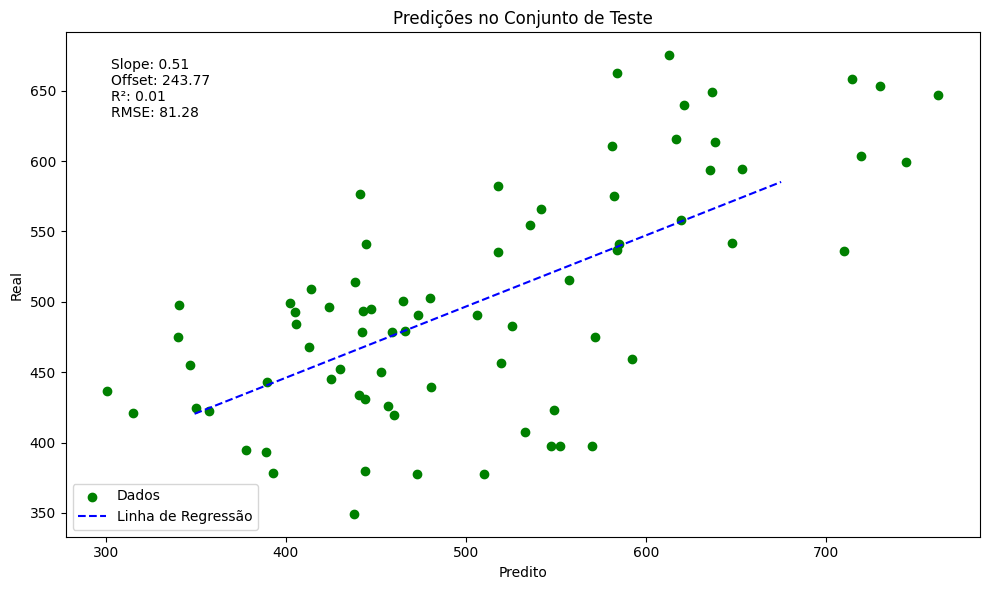

In [22]:
results_snv_firmeza = MLPR(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
infos_snv = add_plot_infos(infos_snv, results_snv_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.9203
Correlation coefficient: 0.9595
RMSE: 0.8882
MAE: 0.5992
Relative absolute error: 25.1261
Root relative squared error: 28.2262
Slope: 1.0187
Offset: -0.2552
=== Cross-Validation Metrics ===
R²: -0.4315
Correlation coefficient: 0.4876
RMSE: 3.7648
MAE: 2.8079
Relative absolute error: 117.7528
Root relative squared error: 119.6462
Slope: 0.3735
Offset: 9.5470
=== Validation Metrics ===
R²: -0.7601
Correlation coefficient: 0.5563
RMSE: 3.1810
MAE: 2.3777
Relative absolute error: 120.4135
Root relative squared error: 132.6700
Slope: 0.3504
Offset: 9.9087


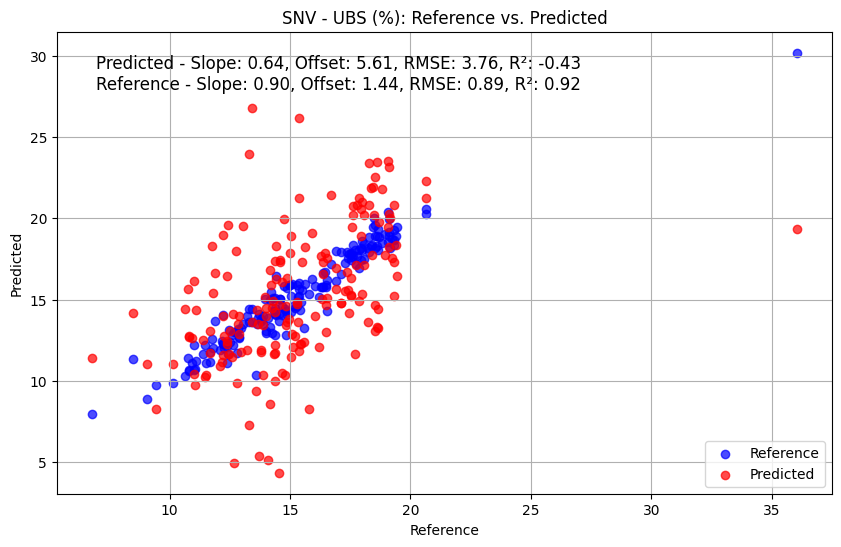

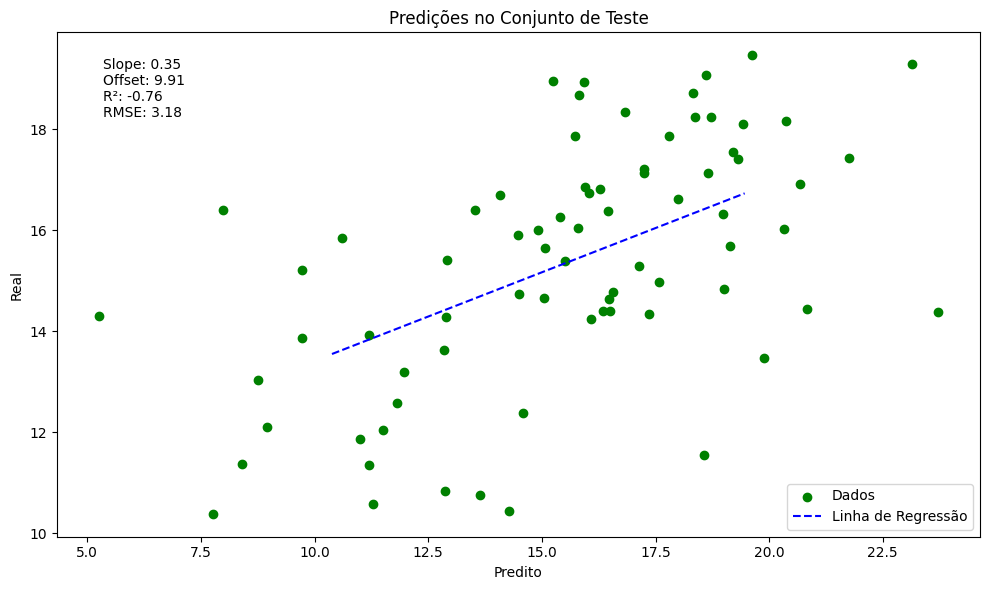

In [23]:
results_snv_ubs = MLPR(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
infos_snv = add_plot_infos(infos_snv, results_snv_ubs, 'UBS (%)')

In [24]:
infos_snv.to_excel('plot_infos_mlpr_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.901363,0.951268,0.817438,0.600717,28.062023,31.406487,0.941193,0.809294
1,SST,Cross-Validation,-0.584226,0.510793,3.276002,2.489570,116.298332,125.866026,0.360240,9.044215
2,SST,Validation,-0.385347,0.547983,2.644209,2.053669,110.485170,117.700751,0.398857,8.456611
3,AT,Training,0.890870,0.944750,0.184724,0.133004,31.484265,33.034854,1.015198,-0.038957
4,AT,Cross-Validation,-0.161723,0.466623,0.602700,0.418456,99.055395,107.783250,0.438828,0.669075
5,AT,Validation,0.310005,0.716563,0.426614,0.319209,75.930380,83.065961,0.615868,0.400178
6,PH,Training,0.548350,0.798574,0.210445,0.164753,66.258260,67.204886,0.728286,0.902622
7,PH,Cross-Validation,-4.102611,0.231003,0.707349,0.539954,217.151459,225.889599,0.104293,2.972343
8,PH,Validation,-1.713594,0.463394,0.406674,0.307654,145.326157,164.729913,0.250875,2.429030
9,FIRMEZA (N),Training,0.982108,0.991725,13.521718,9.655429,11.938423,13.375939,1.039342,-20.310171
